In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import davies_bouldin_score


In [3]:

# Load datasets
customers = pd.read_csv("Customers.csv")
transactions = pd.read_csv("Transactions.csv")



In [4]:
# Convert date columns to datetime format
customers["SignupDate"] = pd.to_datetime(customers["SignupDate"])
transactions["TransactionDate"] = pd.to_datetime(transactions["TransactionDate"])


In [5]:

# Merge transaction data with customer data
customer_transactions = transactions.merge(customers, on="CustomerID")


In [6]:

# Aggregate transaction data per customer
customer_features = customer_transactions.groupby("CustomerID").agg(
    total_spent=("TotalValue", "sum"),
    num_transactions=("TransactionID", "count"),
    avg_order_value=("TotalValue", "mean"),
    unique_products=("ProductID", "nunique")
).reset_index()


In [7]:

# Add categorical customer profile data (Region)
customer_features = customer_features.merge(customers[["CustomerID", "Region"]], on="CustomerID")

# Convert categorical variables (Region) into numerical form using one-hot encoding
customer_features = pd.get_dummies(customer_features, columns=["Region"], drop_first=True)

# Standardize numerical features
scaler = StandardScaler()
features_scaled = scaler.fit_transform(customer_features.drop(columns=["CustomerID"]))


In [8]:

# Determine optimal number of clusters using Elbow Method
wcss = []
for i in range(2, 11):
    kmeans = KMeans(n_clusters=i, random_state=42, n_init=10)
    kmeans.fit(features_scaled)
    wcss.append(kmeans.inertia_)


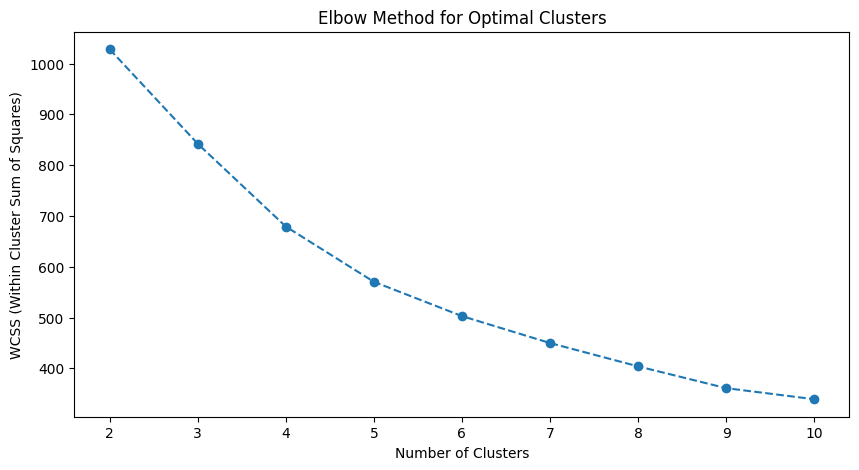

In [9]:

# Plot Elbow Method
plt.figure(figsize=(10, 5))
plt.plot(range(2, 11), wcss, marker="o", linestyle="--")
plt.xlabel("Number of Clusters")
plt.ylabel("WCSS (Within Cluster Sum of Squares)")
plt.title("Elbow Method for Optimal Clusters")
plt.show()


In [10]:

# Apply K-Means Clustering with optimal clusters (choosing k=4 based on analysis)
optimal_clusters = 4
kmeans = KMeans(n_clusters=optimal_clusters, random_state=42, n_init=10)
customer_features["Cluster"] = kmeans.fit_predict(features_scaled)


In [11]:

# Compute Davies-Bouldin Index for cluster evaluation
db_index = davies_bouldin_score(features_scaled, customer_features["Cluster"])
print(f"Davies-Bouldin Index: {db_index}")


Davies-Bouldin Index: 1.191142031485112


In [12]:

# Visualize clusters using PCA (reducing to 2 dimensions)
pca = PCA(n_components=2)
features_pca = pca.fit_transform(features_scaled)
customer_features["PCA1"] = features_pca[:, 0]
customer_features["PCA2"] = features_pca[:, 1]



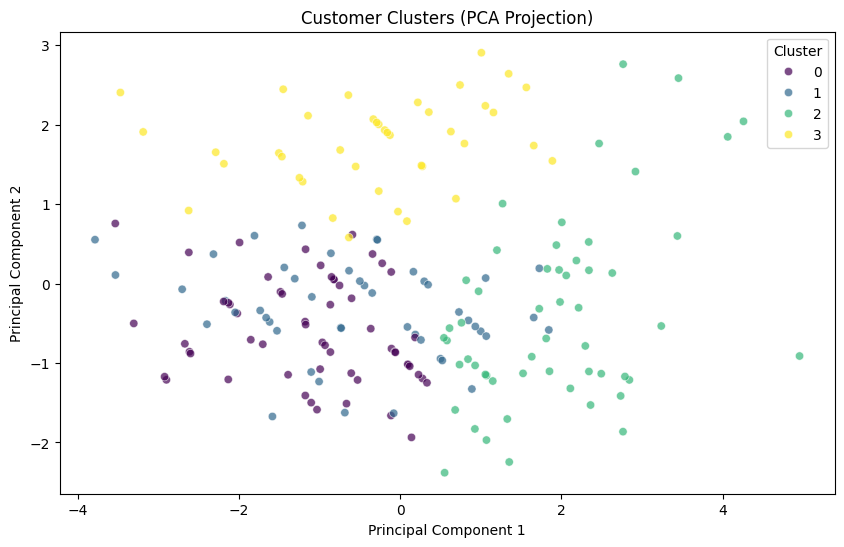

In [13]:

plt.figure(figsize=(10, 6))
sns.scatterplot(x="PCA1", y="PCA2", hue="Cluster", data=customer_features, palette="viridis", alpha=0.7)
plt.title("Customer Clusters (PCA Projection)")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend(title="Cluster")
plt.show()
